In [ ]:
import numpy as np
import pandas as pd

In [ ]:
bike_train = pd.read_csv('train.csv')

In [ ]:
bike_train = bike_train.set_index('date_time')

In [ ]:
bike_test = pd.read_csv('test.csv')

In [ ]:
bike_test = bike_test.set_index('date_time')

In [ ]:
bike = pd.concat([bike_train,bike_test])

In [ ]:
# 1. "일교차가 너무 큰 날씨"를 알기 위한 정보
bike['temp_diff_info'] = bike['high_temp'] - bike['low_temp']
# 2. "덥고 습한 날씨"를 알기 위한 정보
bike['sweat_info'] = bike['high_temp'] * bike['humidity'] 
# 3. "춥고 바람부는 날씨"를 알기 위한 정보
bike['cold_info'] = bike['low_temp'] * bike['wind_speed'] 

In [ ]:
bike.drop(['wind_direction', 'humidity', 'cold_info'], axis=1, inplace=True)

In [ ]:
bike = bike[['sky_condition', 'precipitation_form', 'wind_speed', 'low_temp', 'high_temp', 'Precipitation_Probability', 'temp_diff_info', 'sweat_info', 'number_of_rentals']]

In [ ]:
train_bike_y = bike['number_of_rentals'][0:273]
train_bike_y = train_bike_y.reset_index()
train_bike_y


,date_time,number_of_rentals
0,2018-04-01,22994
1,2018-04-02,28139
2,2018-04-03,26817
3,2018-04-04,26034
4,2018-04-05,2833
...,...,...
268,2020-06-26,96150
269,2020-06-27,107001
270,2020-06-28,98568
271,2020-06-29,70053


In [ ]:
test_bike_y = bike['number_of_rentals'][273:]
test_bike_y = test_bike_y.reset_index()
test_bike_y

,date_time,number_of_rentals
0,2021-04-01,116640
1,2021-04-02,110607
2,2021-04-03,14026
3,2021-04-04,94160
4,2021-04-05,110533
...,...,...
86,2021-06-26,105813
87,2021-06-27,92869
88,2021-06-28,106378
89,2021-06-29,111907


In [ ]:
from fbprophet import Prophet

In [ ]:
train = train_bike_y
test = test_bike_y
# prophet은 ds와 y 두 개의 column으로만 진행
df_prophet = pd.DataFrame({'ds' : train['date_time'], 'y' : train['number_of_rentals']}).reset_index(drop=True) 
prophet_model = Prophet() # 예측값에 상한과 하한을 두지 않을 것이기 때문에 'logistic' 등을 사용하지 않고 default인 'linear' 사용
result = prophet_model.fit(df_prophet)
prophet_test = pd.DataFrame(test['date_time']).rename(columns={'date_time' : 'ds'})
prophet_pred_df = result.predict(prophet_test)
prophet_pred = prophet_pred_df.yhat

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


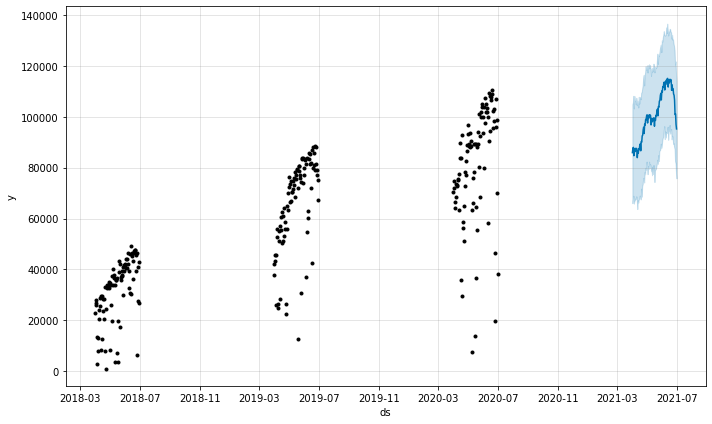

In [ ]:
fig1 = prophet_model.plot(prophet_pred_df)

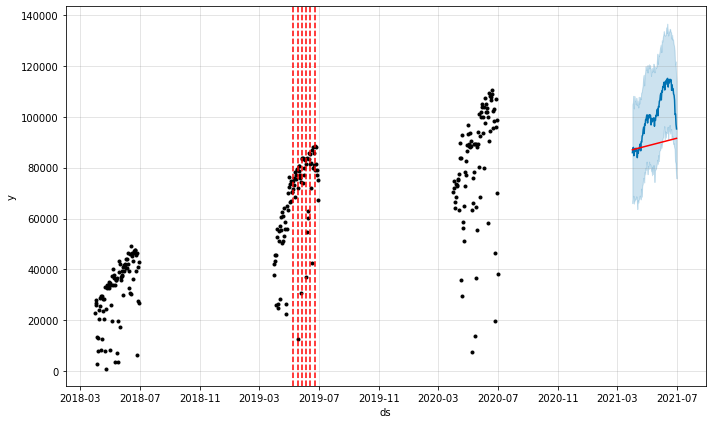

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig = prophet_model.plot(prophet_pred_df)
a = add_changepoints_to_plot(fig.gca(), prophet_model, prophet_pred_df)
fig.savefig('prophet_trend변화시점.png')

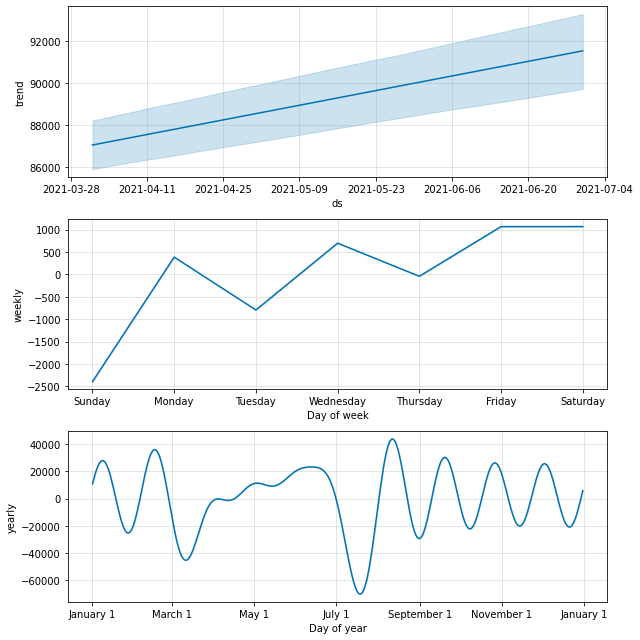

In [ ]:
fig2 = prophet_model.plot_components(prophet_pred_df)

In [ ]:
def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

In [ ]:
NMAE(test['number_of_rentals'], prophet_pred)

0.7478702626827485